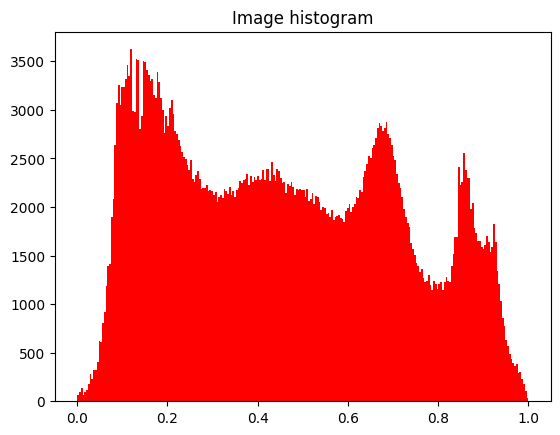

In [36]:
from skimage import color, io, measure, img_as_ubyte, img_as_float, segmentation, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
from sklearn import decomposition




# Read the image.
# Here the directory and the image name is concatenated
# by "+" to give the full path to the image.
im_org = io.imread(
    "ardeche_river.jpg"
) 

im_gray = color.rgb2gray(im_org)  # dataype = float64

# histogram of a gray scale image (float64)
plt.hist(im_gray.ravel(), bins=256, color="red", alpha=1.0)
plt.title("Image histogram")
io.show()

In [2]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    #img_float = img_as_float(img_in)
    min_val = img_in.min()
    max_val = img_in.max()
    min_desired = 0.2
    max_desired = 0.8
	
 
    img_out = ((max_desired - min_desired)/(max_val - min_val)) * (img_in - min_val) + min_desired
 
    # Do something here

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_out

im_out = histogram_stretch(im_gray)


In [3]:
im_avg = np.average(im_out) #threshold
im_avg

0.4761281870330431

In [4]:
from skimage import filters

In [5]:
im_edges = filters.prewitt_h(im_out)
print(im_edges)

[[-0.1197372  -0.14423003 -0.14237918 ... -0.00431844 -0.00981174
  -0.00874549]
 [-0.12551608 -0.15925641 -0.1751738  ... -0.01307006 -0.01721562
  -0.01446512]
 [ 0.00318714 -0.00830305 -0.02786431 ... -0.0126754  -0.00975815
  -0.0080739 ]
 ...
 [-0.00375891 -0.00661943 -0.05253143 ... -0.02198608 -0.04592346
  -0.06907608]
 [-0.01961172 -0.01462466  0.00202059 ...  0.10173118  0.09780142
   0.0711137 ]
 [-0.0326219  -0.03026763 -0.02253321 ...  0.08631736  0.08284183
   0.06041895]]


In [6]:
edges_all_pos = np.abs(im_edges)
max_value = np.max(edges_all_pos)
max_value

0.5331217888704123

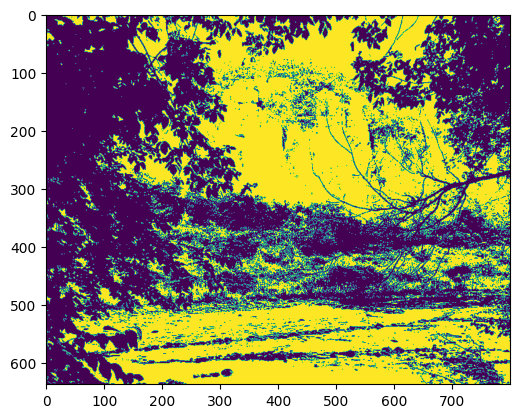

In [7]:
bin_im = im_out > im_avg
plt.imshow(bin_im)
plt.show()

In [8]:
print(bin_im)

number_of_foreground_pixels = np.sum(bin_im)
number_of_foreground_pixels

[[False  True False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ...  True  True  True]]


244910

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
from skimage.util import img_as_ubyte

In [10]:
def imshow_orthogonal_view(sitkImage, origin=None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data / np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap="gray")
    axes[0].set_title("Axial")

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap="gray")
    axes[1].set_title("Coronal")

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap="gray")
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

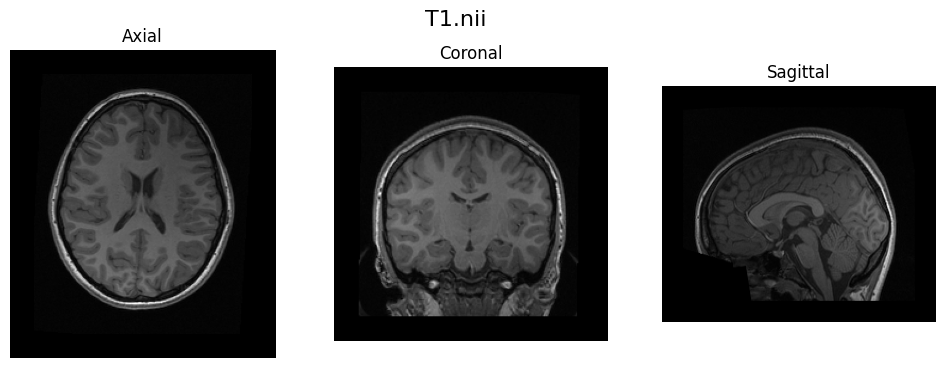

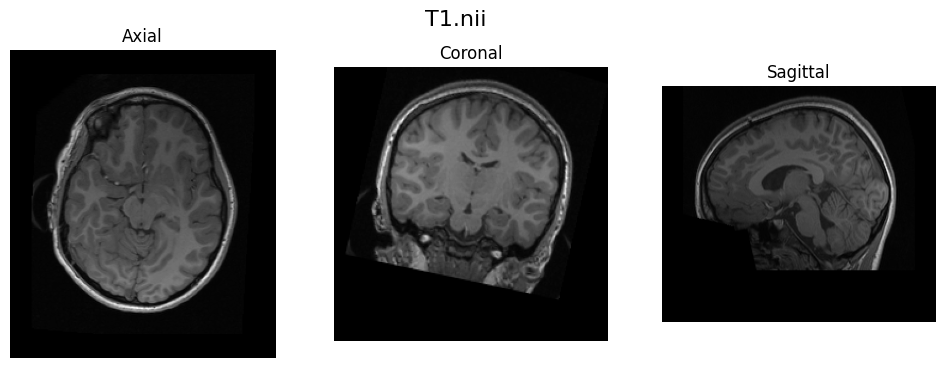

In [11]:
fixed_image = sitk.ReadImage("./examData/ImgT1_v1.nii")
moving_image = sitk.ReadImage("./examData/ImgT1_v2.nii")

# Display the volume

imshow_orthogonal_view(fixed_image, title="T1.nii")
imshow_orthogonal_view(moving_image, title="T1.nii")


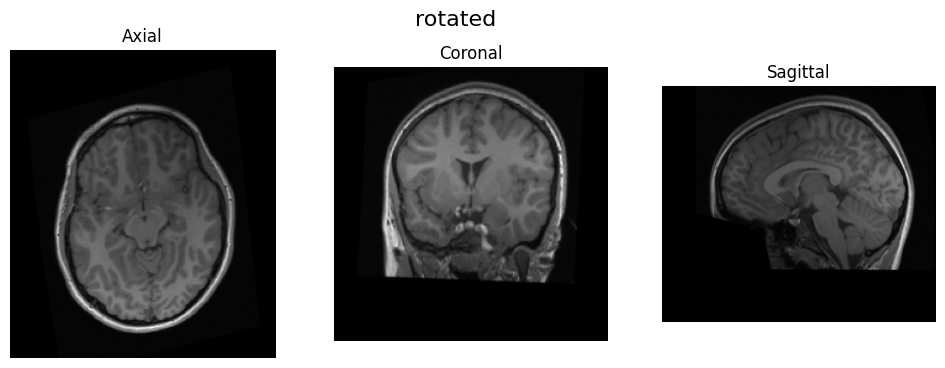

In [12]:
array1 = sitk.GetArrayFromImage(fixed_image)
array2 = sitk.GetArrayFromImage(moving_image)

affine_transform = sitk.AffineTransform(3)
center = np.array(moving_image.GetSize()) / 2 - 0.5

centre_world = moving_image.TransformContinuousIndexToPhysicalPoint(center) # World Coordinate System
affine_transform.SetCenter(centre_world)


A = np.array([
              [0.98, -0.16, 0.17, 0], 
              [0.26, 0.97, 0, -15],
              [-0.17, 0.04, 0.98, 0],
              [0,0,0,1]
            ])

affine_transform.SetMatrix(A[:3, :3].flatten())
affine_transform.SetTranslation(A[:3, 3])


rotated_image = sitk.Resample(moving_image, affine_transform)
imshow_orthogonal_view(rotated_image, title="rotated")
plt.show()


In [13]:
def overlay_slices(sitkImage0, sitkImage1, origin=None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError("The two volumes must have the same shape.")
    if (
        np.min(vol0) < 0 or np.min(vol1) < 0
    ):  # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0 / np.max(vol0))
    G = img_as_ubyte(vol1 / np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title("Axial")

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title("Coronal")

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

(-0.00032285402047333865, 0.20952100431761111, 9.864068814894765e-05, 6.2403440486750625, 0.015183944662502764, 29.360696022290057)

(-0.00032285402047333865, 0.20952100431761111, 9.864068814894765e-05)

(6.2403440486750625, 0.015183944662502764, 29.360696022290057)
itk::simple::CompositeTransform
 CompositeTransform (0x126bfed20)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 644179
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x16a56faf0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 2
     Modified Time: 644169
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.978131 -9.86407e-05 0.207991 
       2.93326e-05 1 0.00033631 
       -0.207991 -0.000322854 0.978131 
     Offset: [-2.92219, 0.00254242, 23.2582]
     Center: [-33.5, -63.5, 40.5]
     Translation: [6.24034, 0.0151839, 29.3607

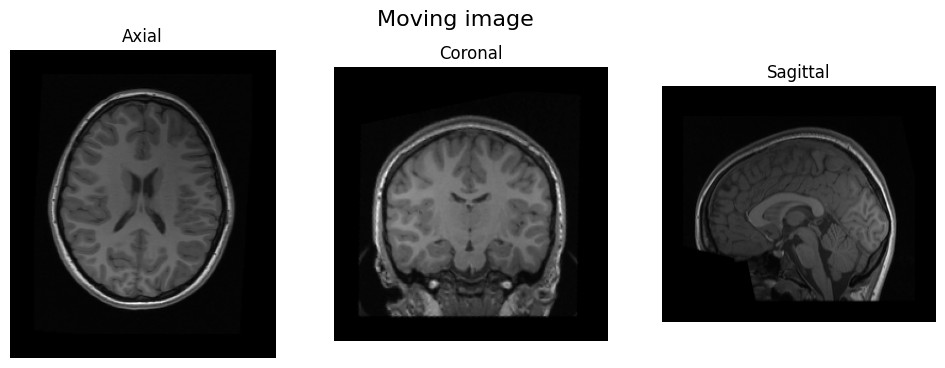

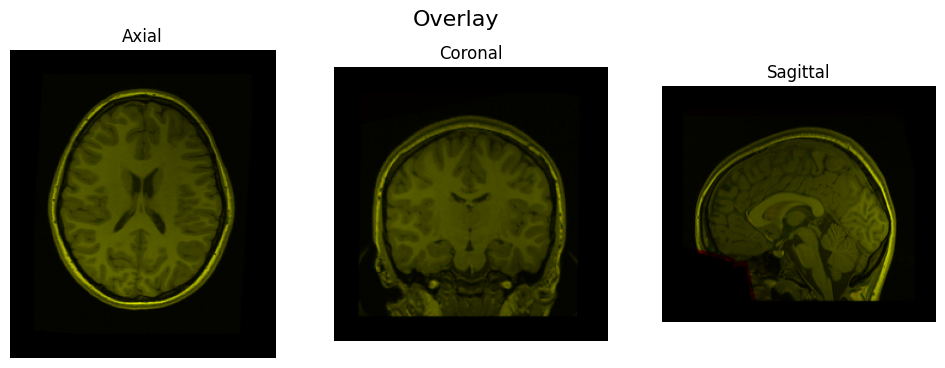

In [15]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors=[2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)


# Initialize the transformation type to rigid
initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image) 

ImgT1_B = sitk.Resample(moving_image, tform_reg)
imshow_orthogonal_view(ImgT1_B, title='Moving image')
overlay_slices(fixed_image, ImgT1_B, title = 'Overlay')

params = tform_reg.GetParameters()  # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)
angles = params[:3]
trans = params[3:6]

print(params)
print()
print(np.rad2deg(angles))
print()
print(trans)


print(tform_reg)

In [18]:
print(np.round(params))
print(np.rad2deg(angles))

[-0.  0.  0.  6.  0. 29.] 3
[-1.84981728e-02  1.20046693e+01  5.65169512e-03]


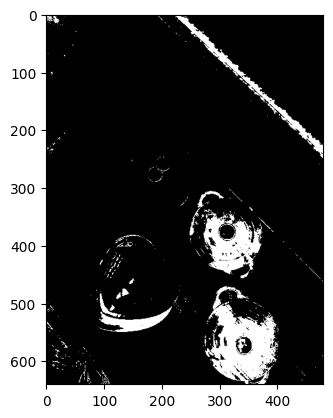

24695

In [31]:
#part 3
im1 = io.imread("./examData/ChangeDetection/frame_1.jpg")
im2 = io.imread("./examData/ChangeDetection/frame_2.jpg")

hsv_img1 = color.rgb2hsv(im1)
hsv_img2 = color.rgb2hsv(im2)

s_img1 = (hsv_img1[:, :, 1]) * 255
s_img2 = (hsv_img2[:, :, 1]) * 255

diff_im = np.abs(s_img1 - s_img2)

avg_val = np.average(diff_im)
std_val = np.std(diff_im)

threshold = avg_val + 2 * std_val

bin_im = (diff_im > threshold)
plt.imshow(bin_im)
plt.show()

number_of_changed_pixels = np.sum(bin_im)
number_of_changed_pixels

In [54]:
print(threshold)
print(avg_val)
print(number_of_changed_pixels)

82.80872852799743
22.794263316311064
24695


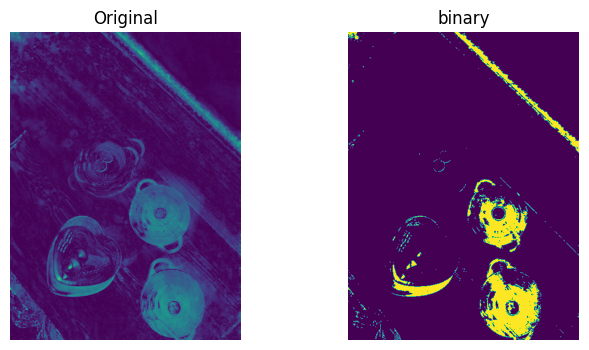

In [33]:
#blob detection
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original)
    ax1.set_title("Original")
    ax1.axis("off")
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis("off")
    io.show()

show_comparison(diff_im, bin_im, "binary")

In [56]:
#BLOB ANALYSIS

label_img = measure.label(bin_im)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")
region_props = measure.regionprops(label_img)

max_area = -1
for region in region_props:
    if region.area > max_area:
        max_area = region.area
print(f"Answer: Area of the largest region {max_area:.0f}")


Number of labels: 365
Answer: Area of the largest region 10350


In [78]:
#DICOM heart analysis
import pydicom as dicom
from skimage.morphology import binary_closing, binary_opening,
from skimage.morphology import disk
from scipy.spatial import distance


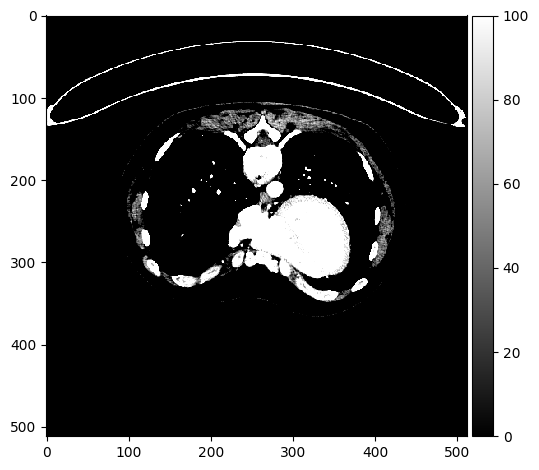

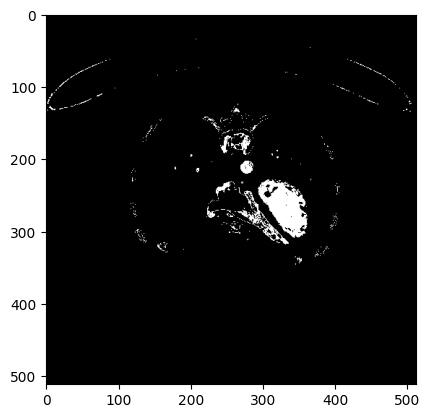

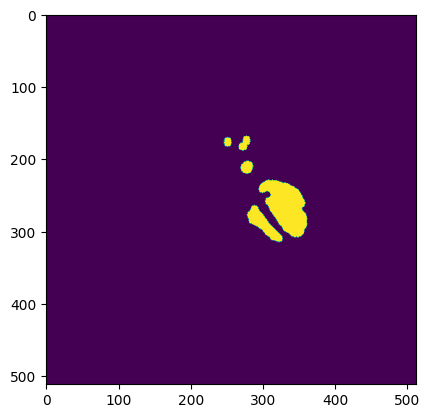

Number of labels: 5


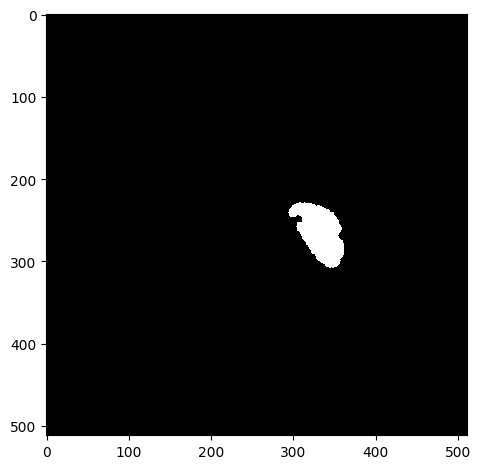

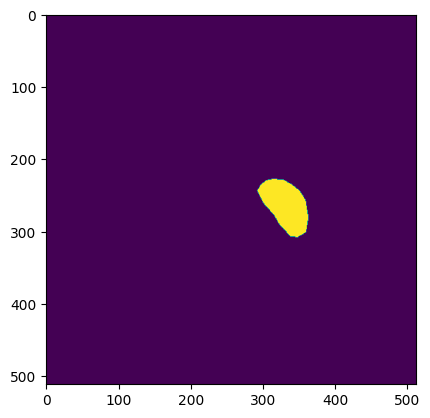

DICE score 0.9375729288214703


In [85]:
ct = dicom.read_file('./examData/HeartCT/1-001.dcm') #single dicom slice w/ annotations
img = ct.pixel_array #extract pixel data, already hounsfield units -> its the format for dicom images
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

roi_myo = io.imread('./examData/HeartCT/MyocardiumROI.png')
myo_mask = roi_myo > 0 #white values
myo_values = img[myo_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_myo = np.mean(myo_values)
std_myo = np.std(myo_values)

roi_blood = io.imread('./examData/HeartCT/BloodROI.png')
blood_mask = roi_blood > 0 #white values
blood_values = img[blood_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_blood = np.mean(blood_values)
std_blood = np.std(blood_values)

myo_max = mu_myo + 3*std_myo 
myo_min = mu_myo - 3*std_myo 
# Create a binary mask for pixels within the specified range
myo_bin = (img > myo_min) & (img < myo_max)


blood_max = mu_blood + 3*std_blood 
blood_min = mu_blood - 3*std_blood 
blood_bin = (img > blood_min) & (img < blood_max)

plt.imshow(blood_bin, cmap = "gray")
plt.show()
'''To clean the binary image, a morphological closing with disk shaped structuring
element of radius 3 is performed followed by a morphological opening with a
structuring element of radius 5:'''

footprint = disk(3)
closed = binary_closing(blood_bin, footprint)
footprint = disk(5)
opened = binary_opening(closed, footprint)

plt.imshow(opened)
plt.show()

label_img = measure.label(opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

max_area = 5000
min_area = 2000


label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    if area < min_area or area > max_area:
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0

#create new bin image with the filtered label image -> should only have the relevant blobs
i_blood = label_img_filter > 0
io.imshow(i_blood)
io.show()


#compare founnd blobs with bloodGT image
bloodGT = io.imread('./examData/HeartCT/BloodGT.png')
plt.imshow(bloodGT)
plt.show()

gt_bin = bloodGT > 0
dice_score = 1 - distance.dice(i_blood.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")


In [86]:
print(f"classrange : {blood_min}, {blood_max}")
threshold_classification = (mu_myo + mu_blood) /2
print(f"classification threshold {threshold_classification}")

classrange : 209.98726921194577, 295.58624588055665
classification threshold 178.41210536488592


In [100]:
#PCA on pistachio nuts
pistachio_data = np.loadtxt('./examData/pistachio_data.txt', comments="%")
x = pistachio_data
n_feat = x.shape[1]
n_obs = x.shape[0]

mean = np.mean(x, axis = 0)  #computes mean of each feature
data = x - mean

std = np.std(data, axis = 0)#computes mean of each feature
data = data / std
#PCA
cov_data = np.cov(data.T) 
max_cov = abs(np.max(cov_data))
min_cov = abs(np.min(cov_data))
max_ans = max(max_cov, min_cov)
print(f"Answer: Max covariance matrix value: {max_ans:.3f}")

    # print(f"Answer: Covariance matrix at (0, 0): {cov_data[0][0]:.3f}")

values, vectors = np.linalg.eig(cov_data)
v_norm = values / values.sum() * 100
    # plt.plot(v_norm)
    # plt.xlabel('Principal component')
    # plt.ylabel('Percent explained variance')
    # plt.ylim([0, 100])
    # plt.show()

answer = v_norm[0] + v_norm[1] + v_norm[2] + v_norm[3]
print(f"Answer: Variance explained by the first four PC: {answer:.2f}")
answer = v_norm[0] + v_norm[1] + v_norm[2] + v_norm[3] + v_norm[4]
print(f"Answer: Variance explained by the first five PC: {answer:.2f}")

# Project data
pc_proj = vectors.T.dot(data.T)
first_proj = pc_proj[:, 0]
sum_sq = np.sum(first_proj ** 2)
print(f"Answer: Sum of squares of first projected data {sum_sq:.2f}")

print(std)
print(std.min()) #eccentrity has smallest std


Answer: Max covariance matrix value: 1.005
Answer: Variance explained by the first four PC: 97.12
Answer: Variance explained by the first five PC: 99.03
Answer: Sum of squares of first projected data 19.60
[1.25854881e+04 3.11384502e+02 3.88908815e+01 2.39958282e+01
 3.16531258e-02 2.74486187e+01 4.73779539e-02 1.23232615e+04
 5.24842185e-02 2.11336093e-01 1.84048710e-01 3.26972072e-02]
0.03165312584880046


In [104]:
from skimage.transform import EuclideanTransform, matrix_transform
from skimage.transform import SimilarityTransform

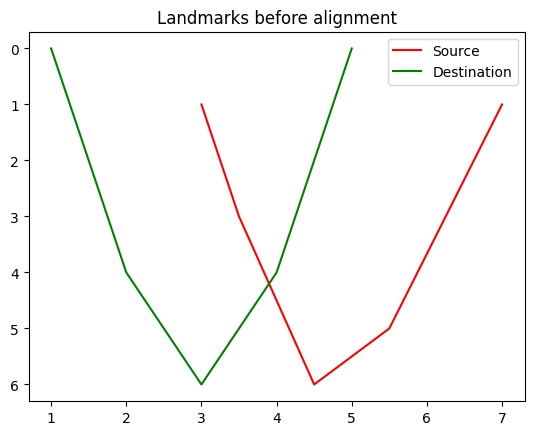

Landmark alignment error F (sum of squared differences): 18.75
Answer: translation [-1.7 -0.4]


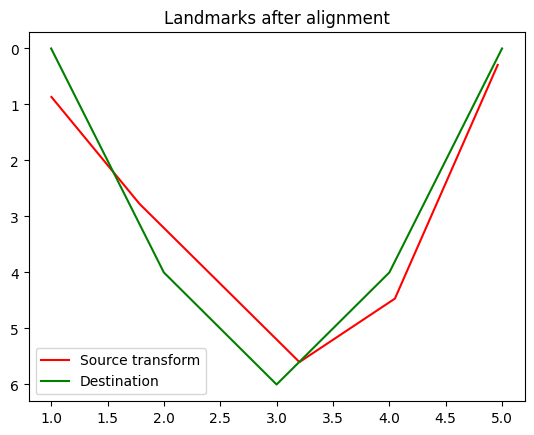

8.226722464108175

In [117]:
#landmark based registration
#write down coordinates of landmarks
src = np.array([[3, 1], [3.5, 3], [4.5, 6], [5.5, 5], [7, 1]])
dst = np.array([[1, 0], [2, 4], [3, 6], [4, 4], [5, 0]])

fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()


e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F (sum of squared differences): {f}")

tform = EuclideanTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params) #similarity transform in numpy array format

cm_1 = np.mean(src, axis=0)  #optimal translation is: take the mean of the two sets of landmarks and subrtact one from the other
cm_2 = np.mean(dst, axis=0)
translations = cm_2 - cm_1
print(f"Answer: translation {translations}")
 # src_transform = src + translations

fig, ax = plt.subplots()
ax.plot(
    src_transform[:, 0],
    src_transform[:, 1],
    "-r",
    markersize=12,
    label="Source transform",
)
ax.plot(dst[:, 0], dst[:, 1], "-g", markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks after alignment")
plt.show()

from math import degrees

abs(degrees(tform.rotation))





In [125]:
import glob
from sklearn import decomposition

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

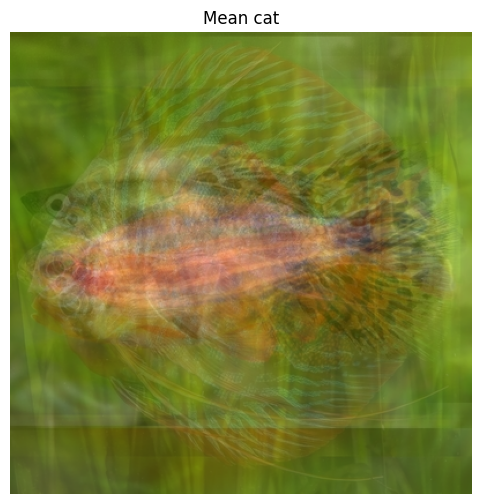

In [126]:
#pca on fish
in_dir = './examData/Fish/'
all_fish = ["discus.jpg", "guppy.jpg", "kribensis.jpg", "neon.jpg", "oscar.jpg", "platy.jpg",
"rummy.jpg", "scalare.jpg", "tiger.jpg", "zebra.jpg"]

n_samples = len(all_fish)
weight = 1/n_samples 

files = glob.glob(f"{in_dir}/*.jpg")
height, width, channels = io.imread(files[0]).shape

data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()
average_fish = np.mean(data_matrix, axis=0)

average_fish_img = create_u_byte_image_from_vector(average_fish, height, width, channels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_fish_img)
ax.set_title("Mean fish")
ax.set_axis_off()
plt.show()



In [127]:
from sklearn.decomposition import PCA

[0.2856439  0.17478062 0.12499749 0.09962871 0.09300163 0.0805709 ]
first two explain :  0.46042452061426736


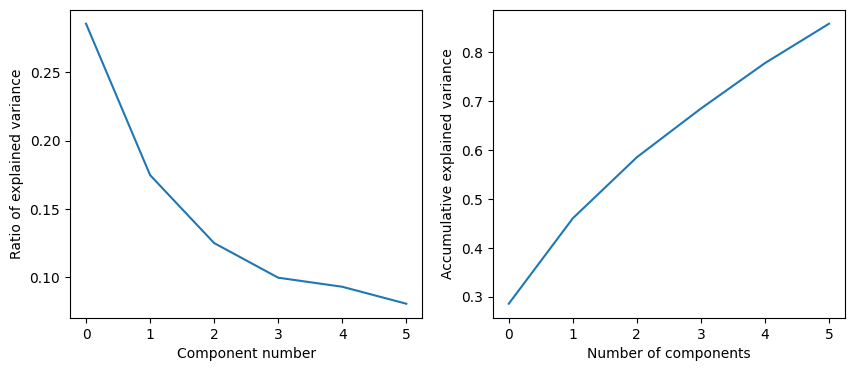

In [131]:
fish_pca = PCA(n_components=6)
fish_pca.fit(data_matrix)

explained_variance = fish_pca.explained_variance_ratio_
print(explained_variance)

print(f"first two explain :  {explained_variance[0] + explained_variance[1]}")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(explained_variance)
ax[0].set_ylabel("Ratio of explained variance")
ax[0].set_xlabel("Component number")
ax[1].plot(explained_variance.cumsum())
ax[1].set_ylabel("Accumulative explained variance")
ax[1].set_xlabel("Number of components")
plt.show()


In [132]:
#pixelwise sum of squared differences
im_favourite = io.imread("examData/Fish/neon.jpg")
im_favourite_flat = im_favourite.flatten()
im_favourite_2 = io.imread("examData/Fish/guppy.jpg")
im_favourite_2_flat = im_favourite_2.flatten()

diff_favourite = im_favourite_flat - im_favourite_2_flat
ssd_dist = np.sum(diff_favourite**2)

print(f"Answer: SSD distance from Neon to Guppy fish {ssd_dist}")


Answer: SSD distance from Neon to Guppy fish 49557848


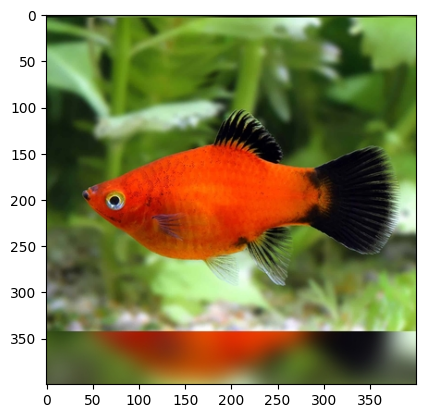

In [137]:
im_favourite_flat = im_favourite_flat.reshape(1, -1)
pca_coords = fish_pca.transform(im_favourite_flat)
pca_coords = pca_coords.flatten()

components = fish_pca.transform(data_matrix)
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
worst_match = np.argmax(pca_distances) #most different fish
worst_twin_fish = data_matrix[worst_match, :]

worst_fish_im = create_u_byte_image_from_vector(worst_twin_fish, height, width, channels)
plt.imshow(worst_fish_im)
plt.show()
#this is a platy fish! 

Done... this took a long time